#Taller 08. Decisiones Bajo Incertidumbre 

- Lina María Moreno
- Juan David Valencia
- Joan Sebastian Jiménez
- Camilo Andrés Figueroa





#Optimización y redes neuronales
El objetivo de esta actividad es afianzar los conocimientos de optimización numérica y su importancia en el entrenamiento de modelos de aprendizaje de máquina.

Para ello se considera el tutorial de reconocimiento de dígitos con el conjunto de datos MNIST de la Guia inicial de TensorFlow 2.0 para principiantes.

El conjunto de entrenamiento contiene 60,000 imágenes de entrenamiento y 10,000 imágenes de validación.

#Actividades

1. Reproduzca el tutorial citado completándolo con la fórmula matemática de la función de pérdida.

2. El entrenamiento con un alto volúmen de imágenes tiene a producir buenos resultados independiente del optimizador. Cambie el método de optimización por

+ SGD
+ RSMprop
+ Adagram
+ Adadelta

  En cada caso varíe la tasa de aprendizaje η=0.001,0.1,0.5,0.9,1.5 manteniendo los otros parámetros del optimizador en sus valores por defecto. Reporte el accuracy en el conjunto de datos en entrenamiento y validaciónn (los 10,000 datos). Reporte las gráficas de la función de pérdida y del accuracy durante el proceso de optimización.

3. Reduzca el volumen de datos al 0.05% (600 datos). Esto eleva la dificultad del problema al contar con menos datos. Repita la actividad del punto anterior. Considerando que el sobreentrenamiento es una diferencia importante en la métrica de desempeño obtenida en entrenamiento y validación responda las siguientes preguntas:

+ ¿Cuál fue el método de optimización menos afectado por la reducción del conjunto de datos?
+ ¿Cuál fue la tasa de aprendizaje menos afectada por la reducción del conjunto de datos?
+ ¿Cuál fue el método que más rápido convergió?


# Resultados

Importación de librerias a ser utilizadas durante el ejercicio:

In [1]:
# Import required libraries

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random as rnd

1. Fórmula matemática de la función de pérdida:

En este ejercicio se utilizará sparse_categorical_crossentropy, se diferencia de categorical_crossentropy porque la última requiere del uso de one hot encoding, en el caso de sparse_categorical_crossentropy las clases son mutuamente excluyentes, en este caso un número solo puede pertenecer a una clase y su representación se puede hacer con números enteros, no con vectores de 1's y 0's. 


Fuentes: 

* https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other

* https://datascience.stackexchange.com/questions/41921/sparse-categorical-crossentropy-vs-categorical-crossentropy-keras-accuracy

In [2]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

La ecuación que se muestra a continuación corresponde a la fórmula de categorical cross-entropy.
N es el número total de los elementos dentro del dataset, **S** el número de muestras y **C** el número de clases. 

$$ -\frac{1}{N} \sum_{s\in S} \sum_{c \in C} 1_{s\in c} log {p(s \in c)} $$

En caso de que las pertenencias de los elementos sean exclusivas a una clase(sparse_categorical_crossentropy) no es necesario sumar sobre las clases, solo se considera el valor interior $$ - log {p(s \in c)} $$ para la verdadera clase **C**, es decir que solo se realiza la sumatoria utilizando las probabilidades de la **clase verdadera** para cada muestra, no sobre todas las clases. 

$$ -\frac{1}{N} \sum_{s\in S}  log {p(s \in c)} $$


In [3]:
#Uso de la función de perdida de la librería de tensorflow
y_true = [1, 2]#Entero => Sparse
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]#Vectores de probabilidad, en nuestro ejercicio son 10
loss = tf.keras.losses.SparseCategoricalCrossentropy()
print(loss(y_true, y_pred).numpy())

1.1769392


In [4]:
#Función matemática manual de la función de perdida que se va a utilizar en el ejercicio 
def mySparseCatLossFunction (y, pred):
  """Función de pérdida: Sparse categorical crossentropy manual"""
  size = len(y)
  accum = 0
  for i in range(size):
    accum += np.log(pred[i][y[i]])
  return ((-1/size) * accum)

Como se puede observar se llego al mismo resultado que al utilizar la librería, por lo que se verifica que el funcionamiento es correcto

In [5]:
mySparseCatLossFunction(y_true, y_pred)

1.176939193690798


Carga y prepara el conjunto de datos [MNIST](http://yann.lecun.com/exdb/mnist/). Convierte los ejemplos de numeros enteros a numeros de punto flotante:

In [6]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 0s 0us/step


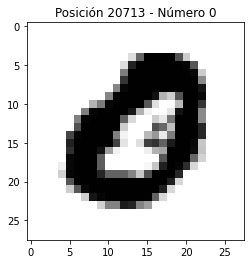

In [7]:
rpos = rnd.randrange(0, len(x_train))
plt.figure()
plt.imshow(x_train[rpos],cmap=plt.cm.binary)
plt.title("Posición {} - Número {}".format(rpos, y_train[rpos]))
plt.show()

2. Realizar el entrenamiento con los datos completos y reportar el accuracy del conjunto de datos de entrenamiento y validación. Para el desarrollo de este ejercicio se tendrán en cuenta los 
siguientes  <strong>hiperparametros a optimizar: </strong>

* Learning rate (0.001,0.1,0.5,0.9,1.5) => (0.001, 0.01, 0.05, 0.1, 0.25,  0.5, 0.75,  0.9, 1, 1.2, 1.35, 1.5)
* Optimizadores (SDG, RSMprop, Adagrad, Adadelta, Adam) 


In [8]:
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.25,  0.5, 0.75,  0.9, 1, 1.2, 1.35, 1.5]
optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam']

Se basa el ejercicio en un modelo `tf.keras.Sequential`  apilando capas. Dento del cuál se van a utilizar los optimizadores y learning_rates definidos anteriormente. En total se van a evaluar 5 optimizadores y por cada optimizador 12 learning rates diferentes, por lo que se realizarían 60 pruebas para este ejercicio, dentro del mismo se guarda las  métricas del rendimiento del modelo tanto en entrenamiento como en validación para análisis posteriores.  

In [9]:
#results = {}
SGD_train = []
RMSprop_train = []
Adagrad_train = []
Adadelta_train = []
Adam_train = []

SGD_val = []
RMSprop_val = []
Adagrad_val = []
Adadelta_val = []
Adam_val = []

for my_optimizer in optimizers:
  for my_lr in learning_rates:
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(10, activation='softmax')
    ])
    #opt = tf.keras.optimizers.Adam(learning_rate=my_lr)
    #str_opt = "tf.keras.optimizers." + optimizers[1] + "(learning_rate=my_lr)"
    str_opt = "tf.keras.optimizers.{}(learning_rate={})".format(my_optimizer, my_lr)
    opt = eval(str_opt)
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=5)
    #results[my_optimizer + str(my_lr) +'_train_acc'] = model.history.history["accuracy"][-1]
    arr_str_t = "{}_train.append(model.history.history['accuracy'][-1])".format(my_optimizer)
    eval(arr_str_t)
    #results[my_optimizer + str(my_lr) +'_test_acc'] = model.evaluate(x_test,  y_test, verbose=2)[1]
    arr_str_v = "{}_val.append(model.evaluate(x_test,  y_test, verbose=2)[1])".format(my_optimizer)
    eval(arr_str_v)

Epoch 1/5
1875/1875 [==============================] - 6s 2ms/step - loss: 1.7144 - accuracy: 0.5165
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 1.0222 - accuracy: 0.7570
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.7596 - accuracy: 0.8023
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6406 - accuracy: 0.8285
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5727 - accuracy: 0.8429
313/313 - 1s - loss: 0.4628 - accuracy: 0.8842
Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7202 - accuracy: 0.8048
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3870 - accuracy: 0.8904
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3245 - accuracy: 0.9088
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2878 - accuracy: 0.9179
Epoch 5/5
1875/1875 [=======================

A continuación se puede observar las gráfica que representa la información obtenida después de reproducir los 60 escenarios posibles entre los learning_rates y optimizadores seleccionados sobre los datos de entrenamiento

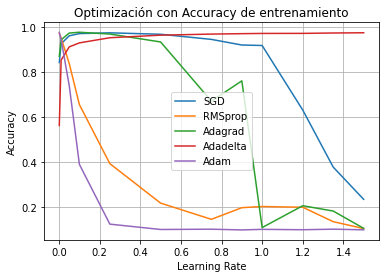

In [10]:
# plot lines 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam' Accuracy vs Learning Rate => For training Accuracy
plt.plot(learning_rates, SGD_train, label = "SGD")
plt.plot(learning_rates, RMSprop_train, label = "RMSprop")
plt.plot(learning_rates, Adagrad_train, label = "Adagrad")
plt.plot(learning_rates, Adadelta_train, label = "Adadelta")
plt.plot(learning_rates, Adam_train, label = "Adam")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Optimización con Accuracy de entrenamiento")
plt.grid()
plt.legend()
plt.show()

A continuación lo propio sobre los datos de validación

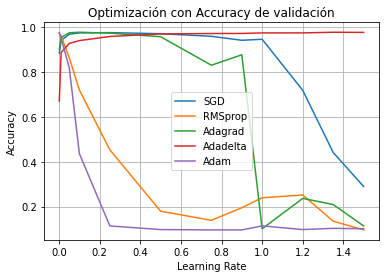

In [11]:
# plot lines 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam' Accuracy vs Learning Rate => For validation Accuracy
plt.plot(learning_rates, SGD_val, label = "SGD")
plt.plot(learning_rates, RMSprop_val, label = "RMSprop")
plt.plot(learning_rates, Adagrad_val, label = "Adagrad")
plt.plot(learning_rates, Adadelta_val, label = "Adadelta")
plt.plot(learning_rates, Adam_val, label = "Adam")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Optimización con Accuracy de validación")
plt.grid()
plt.legend()
plt.show()

Como era de esperarse se puede observar que independiente del optimizador se obtienen buenos resultados debido a la gran cantidad de datos(≈90%), una diferencia notable es que Adadelta tiene un comportamiento muy diferente a los demás, ya que a diferencia del resto de optimizadores que funciona mejor con valores de learning_rate bajos (cercanos a 0), Adadelta funciona mejor con valores altos de learning_rate, a continuación se detalla el comportamiento del accuracy para cada combinación lr - optimizador

In [12]:
#Adagrad Optimization - validation set 
for i in range(len(learning_rates)):
  print("{}. Acc: {}, lr:{}".format(i+1, Adagrad_val[i], learning_rates[i]))

1. Acc: 0.9010999798774719, lr:0.001
2. Acc: 0.9541000127792358, lr:0.01
3. Acc: 0.975600004196167, lr:0.05
4. Acc: 0.9779000282287598, lr:0.1
5. Acc: 0.9739000201225281, lr:0.25
6. Acc: 0.9578999876976013, lr:0.5
7. Acc: 0.8306999802589417, lr:0.75
8. Acc: 0.8773000240325928, lr:0.9
9. Acc: 0.10100000351667404, lr:1
10. Acc: 0.23649999499320984, lr:1.2
11. Acc: 0.20909999310970306, lr:1.35
12. Acc: 0.11349999904632568, lr:1.5


In [13]:
#Adam Optimization - validation set 
for i in range(len(learning_rates)):
  print("{}. Acc: {}, lr:{}".format(i+1, Adam_val[i], learning_rates[i]))

1. Acc: 0.975600004196167, lr:0.001
2. Acc: 0.9517999887466431, lr:0.01
3. Acc: 0.8199999928474426, lr:0.05
4. Acc: 0.4359000027179718, lr:0.1
5. Acc: 0.11349999904632568, lr:0.25
6. Acc: 0.09740000218153, lr:0.5
7. Acc: 0.0957999974489212, lr:0.75
8. Acc: 0.0957999974489212, lr:0.9
9. Acc: 0.11379999667406082, lr:1
10. Acc: 0.09740000218153, lr:1.2
11. Acc: 0.10279999673366547, lr:1.35
12. Acc: 0.10109999775886536, lr:1.5


In [14]:
#SGD Optimization - validation set 
for i in range(len(learning_rates)):
  print("{}. Acc: {}, lr:{}".format(i+1, SGD_val[i], learning_rates[i]))

1. Acc: 0.8841999769210815, lr:0.001
2. Acc: 0.9409999847412109, lr:0.01
3. Acc: 0.9688000082969666, lr:0.05
4. Acc: 0.9750000238418579, lr:0.1
5. Acc: 0.9761999845504761, lr:0.25
6. Acc: 0.9714000225067139, lr:0.5
7. Acc: 0.9598000049591064, lr:0.75
8. Acc: 0.9420999884605408, lr:0.9
9. Acc: 0.9466000199317932, lr:1
10. Acc: 0.7188000082969666, lr:1.2
11. Acc: 0.44130000472068787, lr:1.35
12. Acc: 0.28940001130104065, lr:1.5


In [15]:
#Adadelta Optimization - validation set
for i in range(len(learning_rates)):
  print("{}. Acc: {}, lr:{}".format(i+1, Adadelta_val[i], learning_rates[i]))

1. Acc: 0.6703000068664551, lr:0.001
2. Acc: 0.8873000144958496, lr:0.01
3. Acc: 0.9276999831199646, lr:0.05
4. Acc: 0.9406999945640564, lr:0.1
5. Acc: 0.9589999914169312, lr:0.25
6. Acc: 0.9703999757766724, lr:0.5
7. Acc: 0.9721999764442444, lr:0.75
8. Acc: 0.9725000262260437, lr:0.9
9. Acc: 0.9749000072479248, lr:1
10. Acc: 0.9750000238418579, lr:1.2
11. Acc: 0.9779000282287598, lr:1.35
12. Acc: 0.9771999716758728, lr:1.5


In [16]:
#RMSprop Optimization - validation set
for i in range(len(learning_rates)):
  print("{}. Acc: {}, lr:{}".format(i+1, RMSprop_val[i], learning_rates[i]))

1. Acc: 0.9728000164031982, lr:0.001
2. Acc: 0.9621000289916992, lr:0.01
3. Acc: 0.8646000027656555, lr:0.05
4. Acc: 0.7196000218391418, lr:0.1
5. Acc: 0.45320001244544983, lr:0.25
6. Acc: 0.1793999969959259, lr:0.5
7. Acc: 0.1386999934911728, lr:0.75
8. Acc: 0.19480000436306, lr:0.9
9. Acc: 0.23919999599456787, lr:1
10. Acc: 0.2517000138759613, lr:1.2
11. Acc: 0.1347000002861023, lr:1.35
12. Acc: 0.09589999914169312, lr:1.5


Se analizará la función de perdida y el accuracy para el escenario optimo, que en este caso corresponde a Adadelta y un learning_rate de 1.5

In [17]:
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(10, activation='softmax')
    ])
    #opt = tf.keras.optimizers.Adam(learning_rate=my_lr)
    #str_opt = "tf.keras.optimizers." + optimizers[1] + "(learning_rate=my_lr)"
    #str_opt = "tf.keras.optimizers.{}(learning_rate={})".format(my_optimizer, my_lr)
    opt = tf.keras.optimizers.Adadelta(learning_rate=1.5)
    #opt = eval(str_opt)
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=5)


Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2781 - accuracy: 0.9178
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1426 - accuracy: 0.9575
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1112 - accuracy: 0.9671
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0946 - accuracy: 0.9721
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0827 - accuracy: 0.9747


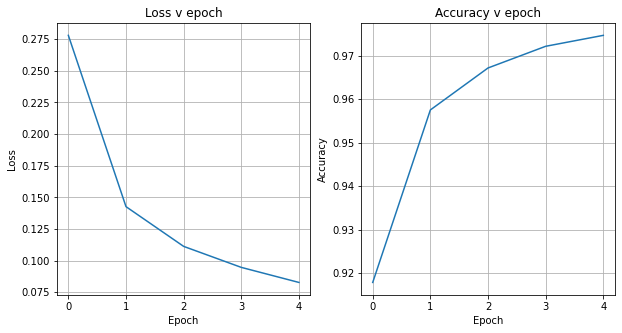

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Loss v epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.plot(history.history['loss'])
plt.subplot(1,2,2)
plt.title("Accuracy v epoch")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.plot(history.history['accuracy'])
plt.show()

3. Reducir el volumen de los datos a 600 

In [19]:
sub_x_train = (x_train)[0:600]
sub_y_train = (y_train)[0:600]

In [20]:
#(x_test, y_test)
#sub_x_test = (x_test)[0:200]
sub_x_test = (x_test)
#sub_y_test = (y_test)[0:200]
sub_y_test = (y_test)

In [21]:
#results = {}
sub_SGD_train = []
sub_RMSprop_train = []
sub_Adagrad_train = []
sub_Adadelta_train = []
sub_Adam_train = []

sub_SGD_val = []
sub_RMSprop_val = []
sub_Adagrad_val = []
sub_Adadelta_val = []
sub_Adam_val = []

for my_optimizer in optimizers:
  for my_lr in learning_rates:
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(10, activation='softmax')
    ])
    #opt = tf.keras.optimizers.Adam(learning_rate=my_lr)
    #str_opt = "tf.keras.optimizers." + optimizers[1] + "(learning_rate=my_lr)"
    str_opt = "tf.keras.optimizers.{}(learning_rate={})".format(my_optimizer, my_lr)
    opt = eval(str_opt)
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(sub_x_train, sub_y_train, epochs=5)
    #results[my_optimizer + str(my_lr) +'_train_acc'] = model.history.history["accuracy"][-1]
    arr_str_t = "sub_{}_train.append(model.history.history['accuracy'][-1])".format(my_optimizer)
    eval(arr_str_t)
    #results[my_optimizer + str(my_lr) +'_test_acc'] = model.evaluate(x_test,  y_test, verbose=2)[1]
    arr_str_v = "sub_{}_val.append(model.evaluate(sub_x_test,  sub_y_test, verbose=2)[1])".format(my_optimizer)
    eval(arr_str_v)

Epoch 1/5
19/19 [==============================] - 0s 2ms/step - loss: 2.4049 - accuracy: 0.0850
Epoch 2/5
19/19 [==============================] - 0s 2ms/step - loss: 2.3773 - accuracy: 0.0900
Epoch 3/5
19/19 [==============================] - 0s 2ms/step - loss: 2.3733 - accuracy: 0.0800
Epoch 4/5
19/19 [==============================] - 0s 2ms/step - loss: 2.3520 - accuracy: 0.1217
Epoch 5/5
19/19 [==============================] - 0s 2ms/step - loss: 2.3301 - accuracy: 0.1167
313/313 - 1s - loss: 2.2923 - accuracy: 0.1452
Epoch 1/5
19/19 [==============================] - 0s 2ms/step - loss: 2.3363 - accuracy: 0.1050
Epoch 2/5
19/19 [==============================] - 0s 2ms/step - loss: 2.1288 - accuracy: 0.2767
Epoch 3/5
19/19 [==============================] - 0s 2ms/step - loss: 1.9490 - accuracy: 0.4517
Epoch 4/5
19/19 [==============================] - 0s 2ms/step - loss: 1.7998 - accuracy: 0.5550
Epoch 5/5
19/19 [==============================] - 0s 2ms/step - loss: 1.6578 - 

In [22]:
sub_SGD_train

[0.11666666716337204,
 0.6449999809265137,
 0.8450000286102295,
 0.8799999952316284,
 0.9166666865348816,
 0.9583333134651184,
 0.903333306312561,
 0.8383333086967468,
 0.6899999976158142,
 0.5066666603088379,
 0.24166665971279144,
 0.1783333271741867]

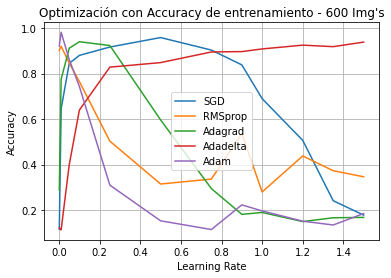

In [23]:
# plot lines 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam' Accuracy vs Learning Rate => For training Accuracy
plt.plot(learning_rates, sub_SGD_train, label = "SGD")
plt.plot(learning_rates, sub_RMSprop_train, label = "RMSprop")
plt.plot(learning_rates, sub_Adagrad_train, label = "Adagrad")
plt.plot(learning_rates, sub_Adadelta_train, label = "Adadelta")
plt.plot(learning_rates, sub_Adam_train, label = "Adam")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Optimización con Accuracy de entrenamiento - 600 Img's")
plt.grid()
plt.legend()
plt.show()

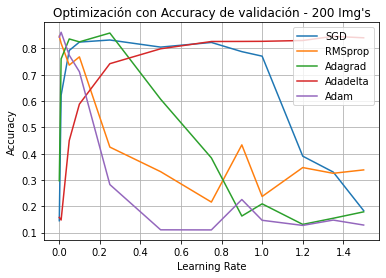

In [24]:
# plot lines 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam' Accuracy vs Learning Rate => For validation Accuracy
plt.plot(learning_rates, sub_SGD_val, label = "SGD")
plt.plot(learning_rates, sub_RMSprop_val, label = "RMSprop")
plt.plot(learning_rates, sub_Adagrad_val, label = "Adagrad")
plt.plot(learning_rates, sub_Adadelta_val, label = "Adadelta")
plt.plot(learning_rates, sub_Adam_val, label = "Adam")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Optimización con Accuracy de validación - 200 Img's")
plt.grid()
plt.legend()
plt.show()

* ¿Cuál fue el método de optimización menos afectado por la reducción del conjunto de datos? 

In [25]:
#Adam_train - sub_Adam_train Que tanto empeoro
zipped_list_Adam = zip(Adam_train, sub_Adam_train)
acc_decrease = [abs(x - y) for (x, y) in zipped_list_Adam]
total_acc_decrease = sum(acc_decrease)
print("Absolute difference in accuracy between Full Data and subsample(600) for Adam: {}".format(total_acc_decrease))

Absolute difference in accuracy between Full Data and subsample(600) for Adam: 1.1990334019064903


In [26]:
#Adam_test - sub_Adam_test Que tanto empeoro
zipped_list_Adam_val = zip(Adam_val, sub_Adam_val)
acc_decrease_val = [abs(x - y) for (x, y) in zipped_list_Adam_val]
total_acc_decrease = sum(acc_decrease_val)
print("Absolute difference in accuracy between Full Data and subsample(600) for Adam (test): {}".format(total_acc_decrease))

Absolute difference in accuracy between Full Data and subsample(600) for Adam (test): 1.0062999427318573


In [27]:
  #Adadelta_train - sub_Adadelta_train Que tanto empeoro
  zipped_list_Adadelta = zip(Adadelta_train, sub_Adadelta_train)
  acc_decrease = [abs(x - y) for (x, y) in zipped_list_Adadelta]
  total_acc_decrease = sum(acc_decrease)
  print("Absolute difference in accuracy between Full Data and subsample(600) for Adadelta: {}".format(total_acc_decrease))

Absolute difference in accuracy between Full Data and subsample(600) for Adadelta: 2.572700060904026


In [28]:
#Adadelta_train - sub_Adadelta_train Que tanto empeoro
zipped_list_Adadelta_val = zip(Adadelta_val, sub_Adadelta_val)
acc_decrease = [abs(x - y) for (x, y) in zipped_list_Adadelta_val]
total_acc_decrease = sum(acc_decrease)
print("Absolute difference in accuracy between Full Data and subsample(600) for Adadelta (test): {}".format(total_acc_decrease))  

Absolute difference in accuracy between Full Data and subsample(600) for Adadelta (test): 3.324099972844124


In [29]:
#SGD_train - sub_SGD_train Que tanto empeoro
zipped_list_Adadelta = zip(Adadelta_train, sub_Adadelta_train)
acc_decrease = [abs(x - y) for (x, y) in zipped_list_Adadelta]
total_acc_decrease = sum(acc_decrease)
print("Absolute difference in accuracy between Full Data and subsample(600) for SGD: {}".format(total_acc_decrease))

Absolute difference in accuracy between Full Data and subsample(600) for SGD: 2.572700060904026


In [30]:
#SGD_test - sub_SGD_test Que tanto empeoro
zipped_list_SGD_val = zip(SGD_val, sub_SGD_val)
acc_decrease = [abs(x - y) for (x, y) in zipped_list_SGD_val]
total_acc_decrease = sum(acc_decrease)
print("Absolute difference in accuracy between Full Data and subsample(600) for SGD (test): {}".format(total_acc_decrease))  

Absolute difference in accuracy between Full Data and subsample(600) for SGD (test): 2.7083999663591385


In [31]:
#Adagrad_test - sub_Adagrad_test Que tanto empeoro
zipped_list_Adagrad_val = zip(Adagrad_val, sub_Adagrad_val)
acc_decrease = [abs(x - y) for (x, y) in zipped_list_Adagrad_val]
total_acc_decrease = sum(acc_decrease)
print("Absolute difference in accuracy between Full Data and subsample(600) for Adagrad (test): {}".format(total_acc_decrease))  

Absolute difference in accuracy between Full Data and subsample(600) for Adagrad (test): 3.051400028169155


In [32]:
#RMSprop_test - sub_RMSprop_test Que tanto empeoro
zipped_list_RMSprop_val = zip(RMSprop_val, sub_RMSprop_val)
acc_decrease = [abs(x - y) for (x, y) in zipped_list_RMSprop_val]
total_acc_decrease = sum(acc_decrease)
print("Absolute difference in accuracy between Full Data and subsample(600) for RMSprop (test): {}".format(total_acc_decrease))  

Absolute difference in accuracy between Full Data and subsample(600) for RMSprop (test): 1.4722000062465668


De todos los optimizadores observados, el que menos empeoro al disminuir el conjunto de datos de entrenamiento fue SGD

In [33]:
for i in range(len(RMSprop_val)):
  print("acc val: {}, acc val subset: {}, diff: {}, lr: {}".format(RMSprop_val[i] , sub_RMSprop_val[i], (RMSprop_val[i] - sub_RMSprop_val[i]), learning_rates[i]))

acc val: 0.9728000164031982, acc val subset: 0.8464999794960022, diff: 0.12630003690719604, lr: 0.001
acc val: 0.9621000289916992, acc val subset: 0.8194000124931335, diff: 0.14270001649856567, lr: 0.01
acc val: 0.8646000027656555, acc val subset: 0.7365000247955322, diff: 0.1280999779701233, lr: 0.05
acc val: 0.7196000218391418, acc val subset: 0.7678999900817871, diff: -0.048299968242645264, lr: 0.1
acc val: 0.45320001244544983, acc val subset: 0.42500001192092896, diff: 0.028200000524520874, lr: 0.25
acc val: 0.1793999969959259, acc val subset: 0.33160001039505005, diff: -0.15220001339912415, lr: 0.5
acc val: 0.1386999934911728, acc val subset: 0.2160000056028366, diff: -0.07730001211166382, lr: 0.75
acc val: 0.19480000436306, acc val subset: 0.4334000051021576, diff: -0.2386000007390976, lr: 0.9
acc val: 0.23919999599456787, acc val subset: 0.23729999363422394, diff: 0.001900002360343933, lr: 1
acc val: 0.2517000138759613, acc val subset: 0.3472000062465668, diff: -0.09549999237060

* ¿Cuál fue la tasa de aprendizaje menos afectada por la reducción del conjunto de datos?


In [34]:
#SGD Optimizer - Test set
for i in range(len(SGD_train)):
  print("acc val: {}, acc val subset: {}, diff: {}, lr: {}".format(SGD_val[i] , sub_SGD_val[i], (SGD_val[i] - sub_SGD_val[i]), learning_rates[i]))

acc val: 0.8841999769210815, acc val subset: 0.1451999992132187, diff: 0.7389999777078629, lr: 0.001
acc val: 0.9409999847412109, acc val subset: 0.6223999857902527, diff: 0.31859999895095825, lr: 0.01
acc val: 0.9688000082969666, acc val subset: 0.7922999858856201, diff: 0.17650002241134644, lr: 0.05
acc val: 0.9750000238418579, acc val subset: 0.8241000175476074, diff: 0.1509000062942505, lr: 0.1
acc val: 0.9761999845504761, acc val subset: 0.8320000171661377, diff: 0.14419996738433838, lr: 0.25
acc val: 0.9714000225067139, acc val subset: 0.8050000071525574, diff: 0.1664000153541565, lr: 0.5
acc val: 0.9598000049591064, acc val subset: 0.822700023651123, diff: 0.1370999813079834, lr: 0.75
acc val: 0.9420999884605408, acc val subset: 0.7878000140190125, diff: 0.15429997444152832, lr: 0.9
acc val: 0.9466000199317932, acc val subset: 0.7706000208854675, diff: 0.17599999904632568, lr: 1
acc val: 0.7188000082969666, acc val subset: 0.390500009059906, diff: 0.32829999923706055, lr: 1.2
ac

Para SGD el learning rate que se vio menos afectado por la reducción del dataset es 1.5


In [35]:
#Adadelta Optimizer - Test set
for i in range(len(Adadelta_train)):
  print("acc val: {}, acc val subset: {}, diff: {}, lr: {}".format(Adadelta_val[i] , sub_Adadelta_val[i], (Adadelta_val[i] - sub_Adadelta_val[i]), learning_rates[i]))

acc val: 0.6703000068664551, acc val subset: 0.15790000557899475, diff: 0.5124000012874603, lr: 0.001
acc val: 0.8873000144958496, acc val subset: 0.14790000021457672, diff: 0.7394000142812729, lr: 0.01
acc val: 0.9276999831199646, acc val subset: 0.44999998807907104, diff: 0.47769999504089355, lr: 0.05
acc val: 0.9406999945640564, acc val subset: 0.5882999897003174, diff: 0.352400004863739, lr: 0.1
acc val: 0.9589999914169312, acc val subset: 0.7419999837875366, diff: 0.21700000762939453, lr: 0.25
acc val: 0.9703999757766724, acc val subset: 0.7986000180244446, diff: 0.17179995775222778, lr: 0.5
acc val: 0.9721999764442444, acc val subset: 0.8263000249862671, diff: 0.1458999514579773, lr: 0.75
acc val: 0.9725000262260437, acc val subset: 0.8266000151634216, diff: 0.14590001106262207, lr: 0.9
acc val: 0.9749000072479248, acc val subset: 0.8270000219345093, diff: 0.14789998531341553, lr: 1
acc val: 0.9750000238418579, acc val subset: 0.8300999999046326, diff: 0.14490002393722534, lr: 1.

Para Adadelta el learning rate que se vio menos afectado por la reducción del dataset es 1.35


In [36]:
#Adam Optimizer - Test set
for i in range(len(Adam_train)):
  print("acc val: {}, acc val subset: {}, diff: {}, lr: {}".format(Adam_val[i] , sub_Adam_val[i], (Adam_val[i] - sub_Adam_val[i]), learning_rates[i]))

acc val: 0.975600004196167, acc val subset: 0.8428999781608582, diff: 0.13270002603530884, lr: 0.001
acc val: 0.9517999887466431, acc val subset: 0.8615000247955322, diff: 0.09029996395111084, lr: 0.01
acc val: 0.8199999928474426, acc val subset: 0.7742000222206116, diff: 0.045799970626831055, lr: 0.05
acc val: 0.4359000027179718, acc val subset: 0.7114999890327454, diff: -0.27559998631477356, lr: 0.1
acc val: 0.11349999904632568, acc val subset: 0.2825999855995178, diff: -0.16909998655319214, lr: 0.25
acc val: 0.09740000218153, acc val subset: 0.11060000211000443, diff: -0.013199999928474426, lr: 0.5
acc val: 0.0957999974489212, acc val subset: 0.11020000278949738, diff: -0.014400005340576172, lr: 0.75
acc val: 0.0957999974489212, acc val subset: 0.2257000058889389, diff: -0.1299000084400177, lr: 0.9
acc val: 0.11379999667406082, acc val subset: 0.1467999964952469, diff: -0.032999999821186066, lr: 1
acc val: 0.09740000218153, acc val subset: 0.12729999423027039, diff: -0.0298999920487

Para Adam el learning rate que se vio menos afectado por la reducción del dataset es 0.05


In [37]:
#RMSprop Optimizer - Test set
for i in range(len(RMSprop_train)):
  print("acc val: {}, acc val subset: {}, diff: {}, lr: {}".format(RMSprop_val[i] , sub_RMSprop_val[i], (RMSprop_val[i] - sub_RMSprop_val[i]), learning_rates[i]))

acc val: 0.9728000164031982, acc val subset: 0.8464999794960022, diff: 0.12630003690719604, lr: 0.001
acc val: 0.9621000289916992, acc val subset: 0.8194000124931335, diff: 0.14270001649856567, lr: 0.01
acc val: 0.8646000027656555, acc val subset: 0.7365000247955322, diff: 0.1280999779701233, lr: 0.05
acc val: 0.7196000218391418, acc val subset: 0.7678999900817871, diff: -0.048299968242645264, lr: 0.1
acc val: 0.45320001244544983, acc val subset: 0.42500001192092896, diff: 0.028200000524520874, lr: 0.25
acc val: 0.1793999969959259, acc val subset: 0.33160001039505005, diff: -0.15220001339912415, lr: 0.5
acc val: 0.1386999934911728, acc val subset: 0.2160000056028366, diff: -0.07730001211166382, lr: 0.75
acc val: 0.19480000436306, acc val subset: 0.4334000051021576, diff: -0.2386000007390976, lr: 0.9
acc val: 0.23919999599456787, acc val subset: 0.23729999363422394, diff: 0.001900002360343933, lr: 1
acc val: 0.2517000138759613, acc val subset: 0.3472000062465668, diff: -0.09549999237060

Para RMSprop el learning rate que se vio menos afectado por la reducción del dataset es 1


In [38]:
#Adagrad Optimizer - Test set
for i in range(len(Adagrad_train)):
  print("acc val: {}, acc val subset: {}, diff: {}, lr: {}".format(Adagrad_val[i] , sub_Adagrad_val[i], (Adagrad_val[i] - sub_Adagrad_val[i]), learning_rates[i]))

acc val: 0.9010999798774719, acc val subset: 0.2971999943256378, diff: 0.6038999855518341, lr: 0.001
acc val: 0.9541000127792358, acc val subset: 0.760200023651123, diff: 0.1938999891281128, lr: 0.01
acc val: 0.975600004196167, acc val subset: 0.8360000252723694, diff: 0.1395999789237976, lr: 0.05
acc val: 0.9779000282287598, acc val subset: 0.8248999714851379, diff: 0.15300005674362183, lr: 0.1
acc val: 0.9739000201225281, acc val subset: 0.8585000038146973, diff: 0.11540001630783081, lr: 0.25
acc val: 0.9578999876976013, acc val subset: 0.6069999933242798, diff: 0.35089999437332153, lr: 0.5
acc val: 0.8306999802589417, acc val subset: 0.383899986743927, diff: 0.44679999351501465, lr: 0.75
acc val: 0.8773000240325928, acc val subset: 0.16300000250339508, diff: 0.7143000215291977, lr: 0.9
acc val: 0.10100000351667404, acc val subset: 0.2092999964952469, diff: -0.10829999297857285, lr: 1
acc val: 0.23649999499320984, acc val subset: 0.13120000064373016, diff: 0.10529999434947968, lr: 1.

Para Adagrad el learning rate que se vio menos afectado por la reducción del dataset es 1.35


* ¿Cuál fue el método que más rápido convergió?  

El método que más rapido puede converger es el <b>Adadelta</b>, debido a que para alcanzar un buen rendimiento requiere de valores altos de learning rate, el learning rate determina que tan largo sea el camino que tomara el algoritmo de optimización por lo que el Adadelta al funcionar mejor con valores altos, tardara menos tiempo en realizar la optimización ya que a diferencia de los demás métodos dará pasos más largos.
